In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeNormal, RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib
from sklearn.model_selection import train_test_split

In [2]:
print(matplotlib.__version__)
print(tf.__version__)

3.7.1
2.10.0


In [3]:
def load_image_paths_by_class(dataset_path):
    
    #สร้าง dictionary 
    class_image_paths = {}

    for class_name in os.listdir(dataset_path): #os.listdir ดึงรายชื่อไฟล์/โฟเดอร์ใน paht
        class_dir = os.path.join(dataset_path, class_name)#os.path.join = images\photo.jpg
        #print(class_dir)
        if os.path.isdir(class_dir):#ตรวจสอบclass_dir เป็นโฟลเดอร์ถ้าเป็นโฟลเดอร์ จะเข้าไปทำงานต่อ
            image_files = [ 
                os.path.join(class_dir, img) #
                for img in os.listdir(class_dir) # ดึงรายชื่อ
                if img.lower().endswith(('.jpg', '.jpeg', '.png')) #
            ]
            if len(image_files) >= 9:  # ขั้นต่ำ 3 ภาพผป
                class_image_paths[class_name] = image_files # สร้าง dictionary

    return class_image_paths


In [4]:
#dataset_path = r'C:\InceptionNet\mediamdata' 
dataset_path3 = r"D:\InceptionNet\GLint360K\glint360k_3"
dic = load_image_paths_by_class(dataset_path3)
print(len(dic))
#print(dictm)


15757


In [9]:
classes = list(dic.keys())
#print(classes)
#print(len(classes))

In [10]:
train_classes, val_classes = train_test_split(classes, test_size=0.2, random_state=42)

print(f"จำนวนคลาสสำหรับ Training: {len(train_classes)}")
print(f"จำนวนคลาสสำหรับ Validation: {len(val_classes)}")


จำนวนคลาสสำหรับ Training: 11225
จำนวนคลาสสำหรับ Validation: 2807


In [11]:
train_image_dict1 = {
    class_name: dic[class_name]
    for class_name in train_classes
}

# สร้าง dictionary สำหรับ Validation
val_image_dict1 = {
    class_name: dic[class_name]
    for class_name in val_classes
}
print(f"ขนาดของ Dictionary สำหรับ Training: {len(train_image_dict1)}")
print(f"ขนาดของ Dictionary สำหรับ Validation: {len(val_image_dict1)}")



ขนาดของ Dictionary สำหรับ Training: 11225
ขนาดของ Dictionary สำหรับ Validation: 2807


In [ ]:
#print("\n--- รายชื่อคลาสสำหรับ Training ---")
#for class_name in train_classes:
    #print(class_name)

# ---
# ปริ้นชื่อคลาสสำหรับ Validation
print("\n--- รายชื่อคลาสสำหรับ Validation ---")
for class_name in val_classes:
    print(class_name)

In [13]:
def loadimage(image_path):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = tf.cast(img, tf.float32)
        img = img / 255.0  # Normalization
        img = tf.clip_by_value(img, 0.0, 1.0)#img = tf.where(tf.math.is_finite(img), img, tf.zeros_like(img)) # แทนที่ค่า NaN หรือ Inf ด้วย 0
        img.set_shape((224, 224, 3))
        return img
    except:
        print(f"Error loading image {image_path}. Returning a zero tensor.")
        return tf.zeros((224, 224, 3), dtype=tf.float32)
    
    

##Online Triplet Mining

In [14]:
import random
def triplet_generator(image_dict, num_triplets_per_epoch):
    # image_dict คือ dictionary ของคุณที่ได้จากขั้นตอนที่ 1
    # num_triplets_per_epoch คือจำนวน triplet ที่ต้องการใน 1 รอบ (epoch)
    classes = list(image_dict.keys()) # ดึงชื่อคลาสทั้งหมด
    for _ in range(num_triplets_per_epoch):
        # 1. สุ่ม anchor และ positive จากคลาสเดียวกัน
        anchor_class = random.choice(classes)
        # ตรวจสอบว่าคลาสนั้นมีรูปภาพอย่างน้อย 2 รูป
        if len(image_dict[anchor_class]) < 2:
            continue

        a, p = random.sample(image_dict[anchor_class], 2)
        
        # 2. สุ่ม negative จากคลาสอื่น
        neg_classes = [c for c in classes if c != anchor_class]
        if not neg_classes:
            continue
            
        negative_class = random.choice(neg_classes)
        n = random.choice(image_dict[negative_class])
        
        # คืนค่า (yield) Path ของรูปภาพ
        yield (a, p, n)
        

In [18]:
def builddataset1(image_dict, num_triplets, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: triplet_generator(image_dict, num_triplets),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )
    dataset = dataset.map(
        lambda a, p, n: (loadimage(a), loadimage(p), loadimage(n)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) #เพิ่มมิติ btach
    return dataset

triple = 100
BATCH_SIZE = 4

train_dataset = builddataset1(train_image_dict1, triple, BATCH_SIZE)
val_dataset = builddataset1(val_image_dict1, int(triple*0.1), BATCH_SIZE)

In [ ]:
l = 0

# ทดสอบ
for a, p, n in train_dataset.take(5):
    print("Anchor batch shape:", a.shape)
    print("Positive batch shape:", p.shape)
    print("Negative batch shape:", n.shape)
    print("ลูปที่:", a)
    #l = l + 1Q
    print("ลูปที่:", l)

Anchor batch shape: (4, 224, 224, 3)
Positive batch shape: (4, 224, 224, 3)
Negative batch shape: (4, 224, 224, 3)
ลูปที่: tf.Tensor(
[[[[7.96078444e-01 8.50980401e-01 8.54901969e-01]
   [7.96078444e-01 8.50980401e-01 8.54901969e-01]
   [7.96078444e-01 8.50980401e-01 8.54901969e-01]
   ...
   [7.73529410e-01 8.36274505e-01 8.33333313e-01]
   [7.83333361e-01 8.46078455e-01 8.45098019e-01]
   [7.88235307e-01 8.50980401e-01 8.50980401e-01]]

  [[7.96078444e-01 8.50980401e-01 8.54901969e-01]
   [7.96078444e-01 8.50980401e-01 8.54901969e-01]
   [7.96078444e-01 8.50980401e-01 8.54901969e-01]
   ...
   [7.66176462e-01 8.28921556e-01 8.25980365e-01]
   [7.76960790e-01 8.39705884e-01 8.38725507e-01]
   [7.82352924e-01 8.45098019e-01 8.45098019e-01]]

  [[7.96078444e-01 8.50980401e-01 8.54901969e-01]
   [7.96078444e-01 8.50980401e-01 8.54901969e-01]
   [7.96078444e-01 8.50980401e-01 8.54901969e-01]
   ...
   [7.51470566e-01 8.14215660e-01 8.11274529e-01]
   [7.64215708e-01 8.26960802e-01 8.25980

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Lambda, Input,Dropout

In [ ]:

def QQQ():
    input_shape = (224, 224, 3)

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    # เพิ่มโค้ดนี้ในฟังก์ชัน cor() ก่อน return model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128)(x)
    embedding = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    
    # สร้างโมเดลและ return
    model = Model(inputs=base_model.input, outputs=embedding)
    
    return model

In [25]:
def create_resnet_facenet(input_shape=(160, 160, 3), embedding_dim=128):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = Dropout(0.5)(x)
    x = Dense(embedding_dim)(x)
    embedding = Lambda(lambda y: tf.math.l2_normalize(y, axis=1), name='l2_normalization')(x)

    # สร้าง Model
    model = Model(inputs=inputs, outputs=embedding)
    return model

In [26]:
model = QQQ()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [28]:
def triplet_loss(anchor, positive, negative, alpha=0.2):
    epsilon = 1e-8
    
    # คำนวณระยะห่างแบบ Euclidean squared
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    
    # เพิ่ม epsilon และใช้ tf.clip_by_value เพื่อป้องกันค่าผิดปกติ
    pos_dist = tf.clip_by_value(pos_dist, epsilon, 10.0)
    neg_dist = tf.clip_by_value(neg_dist, epsilon, 10.0)
    
    # คำนวณ basic loss
    basic_loss = pos_dist - neg_dist + alpha
    
    # ใช้ tf.nn.relu แทน tf.maximum
    loss = tf.reduce_mean(tf.nn.relu(basic_loss))
    
    # ตรวจสอบ NaN
    loss = tf.where(tf.math.is_finite(loss), loss, tf.constant(0.0))
    
    return loss


In [29]:
import tensorflow as tf

def losshard_mining(anchor, positive, negative, alpha=0.2):
    """
    Computes Triplet Loss with Hard Triplet Mining.
    """
    # 1. Calculate squared Euclidean distances
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

    # 2. Find all valid triplets in the batch
    all_triplets = pos_dist - neg_dist + alpha
    
    # 3. Filter out the easy triplets (loss <= 0)
    hard_triplets = tf.where(all_triplets > 0, all_triplets, tf.zeros_like(all_triplets))

    # 4. Take the mean of the hard triplets
    # Add a small value to the denominator to avoid division by zero
    num_hard_triplets = tf.reduce_sum(tf.cast(hard_triplets > 0, dtype=tf.float32))
    
    # Check if there are any hard triplets. If not, the loss is 0
    if num_hard_triplets > 0:
        loss = tf.reduce_sum(hard_triplets) / num_hard_triplets
    else:
        loss = tf.constant(0.0)

    # Return the loss
    return loss

In [ ]:
@tf.function
def triplet_loss_val(anchor, positive, negative, alpha=0.2):
    epsilon = 1e-8
    
    # คำนวณระยะห่างแบบ Euclidean squared
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    
    # เพิ่ม epsilon และใช้ tf.clip_by_value เพื่อป้องกันค่าผิดปกติ
    pos_dist = tf.clip_by_value(pos_dist, epsilon, 10.0)
    neg_dist = tf.clip_by_value(neg_dist, epsilon, 10.0)
    
    # คำนวณ basic loss
    basic_loss = pos_dist - neg_dist + alpha
    
    # ใช้ tf.nn.relu แทน tf.maximum
    loss = tf.reduce_mean(tf.nn.relu(basic_loss))
    
    # ตรวจสอบ NaN
    loss = tf.where(tf.math.is_finite(loss), loss, tf.constant(0.0))
    
    return loss

In [30]:
@tf.function
def train_step(anchor, positive, negative):
    with tf.GradientTape() as tape:
        anchor_embedding = model(anchor, training=True)
        positive_embedding = model(positive, training=True)
        negative_embedding = model(negative, training=True)
        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

--- เริ่มการฝึกโมเดล ---

--- Epoch 1/50 ---
Batch 5000, Training Loss: 0.2273
Batch 10000, Training Loss: 0.1292
Batch 15000, Training Loss: 0.1406

สรุป Epoch 1/50, Training Loss เฉลี่ย: 0.1810

--- เริ่ม Validation ---
Validation Batch 500, Validation Loss: 0.2207
Validation Batch 1000, Validation Loss: 0.1797
Validation Batch 1500, Validation Loss: 0.2212
สรุป Validation Loss เฉลี่ย: 0.1809

--- Epoch 2/50 ---
Batch 5000, Training Loss: 0.1683
Batch 10000, Training Loss: 0.1406
Batch 15000, Training Loss: 0.1708

สรุป Epoch 2/50, Training Loss เฉลี่ย: 0.1581

--- เริ่ม Validation ---
Validation Batch 500, Validation Loss: 0.1924
Validation Batch 1000, Validation Loss: 0.1721
Validation Batch 1500, Validation Loss: 0.1740
สรุป Validation Loss เฉลี่ย: 0.1554

--- Epoch 3/50 ---
Batch 5000, Training Loss: 0.1243
Batch 10000, Training Loss: 0.1905
Batch 15000, Training Loss: 0.0385

สรุป Epoch 3/50, Training Loss เฉลี่ย: 0.1470

--- เริ่ม Validation ---
Validation Batch 500, Validation

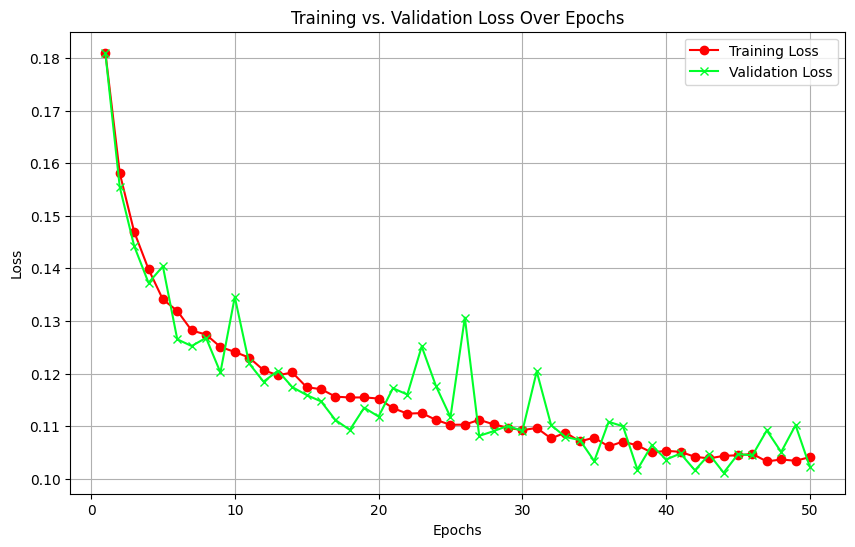


--- การฝึกโมเดลเสร็จสิ้น ---


In [31]:
EPOCHS = 50
print("--- เริ่มการฝึกโมเดล ---")
train_loss_history = []
val_loss_history = []
for epoch in range(EPOCHS):
    total_loss = 0.0
    num_batches = 0
    
    # วนลูปใน training dataset
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    for anchor, positive, negative in train_dataset:
        loss = train_step(anchor, positive, negative)
        total_loss += loss
        num_batches += 1
        
        # ปริ้นท์
        if num_batches % 5000 == 0:
            print(f"Batch {num_batches}, Training Loss: {loss.numpy():.4f}")
    
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    print(f"\nสรุป Epoch {epoch+1}/{EPOCHS}, Training Loss เฉลี่ย: {avg_loss.numpy():.4f}")
    train_loss_history.append(avg_loss)
    # Optional: ตรวจสอบ Validation Loss ในแต่ละ Epoch
    val_total_loss = 0.0
    val_num_batches = 0
    
    # วนลูปใน validation dataset
    print("\n--- เริ่ม Validation ---")
    for anchor, positive, negative in val_dataset:
        anchor_embedding = model(anchor, training=False)
        positive_embedding = model(positive, training=False)
        negative_embedding = model(negative, training=False)
        val_loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        val_total_loss += val_loss
        val_num_batches += 1
        
        # ปริ้นท์ Val
        if val_num_batches % 500 == 0:
             print(f"Validation Batch {val_num_batches}, Validation Loss: {val_loss.numpy():.4f}")
             
    val_avg_loss = val_total_loss / val_num_batches if val_num_batches > 0 else 0
    print(f"สรุป Validation Loss เฉลี่ย: {val_avg_loss.numpy():.4f}")
    val_loss_history.append(val_avg_loss)
    nameModel = f"modelR{epoch+1}.h5"
    model.save(nameModel)

plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_loss_history, 'o-', label='Training Loss',color='red')
plt.plot(range(1, EPOCHS + 1), val_loss_history, 'x-', label='Validation Loss',color="#00FF2A")
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- การฝึกโมเดลเสร็จสิ้น ---")
model.save("2M.h5")


In [ ]:
import tensorflow as tf

def hard_mining(anchor, positive, negative, alpha=0.2):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    hardest_pos_dist = tf.reduce_max(pos_dist)
    hardest_neg_dist = tf.reduce_min(neg_dist)
    basic_loss = hardest_pos_dist - hardest_neg_dist + alpha
    loss = tf.nn.relu(basic_loss)
    return loss